# Model related code
Made by: Tashyan Artyom, U2110268

### Imports and parameters

In [1]:
# Imports
import pickle
import re
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

from torch import tensor, optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Parameters and constants
MAX_LEN = 10000
learning_rate = 0.00001
epochs = 30
batch_size = 64
hidden_size = 64
hidden_size_2 = 10
dropout_coefficient = 0.3
train_factor = 0.6
test_factor = 0.2
valid_factor = 0.2
fresh_start = False

nltk.download('stopwords')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")

Selected device: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sqdar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data preparation

In [3]:
# Uploading our data from csv
df = pd.read_csv("./data/data.csv")
df["text"] = df["text"].fillna("")
df.head()

,Unnamed: 0,text,label
0,0,"Buck up, your troubles caused by small dimensi...",1
1,1,\nUpgrade your sex and pleasures with these te...,1
2,2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,3,Would anyone object to removing .so from this ...,0
4,4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


In [4]:
def preprocess_text(text: str) -> str:
    lower_text = text.lower()
    text_without_links = re.sub(r'http\S+|www\S+|https\S+', '', lower_text, flags=re.MULTILINE)
    plain_text = re.sub(r'[^a-zA-Z\s]', '', text_without_links)
    return plain_text

In [5]:
def tokenizer(text) -> list[str]:
    stemmer = PorterStemmer()
    tokens = re.findall(r'\b\w+\b', text)
    
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [6]:
# Dataset
class EmailDataset(Dataset):
    def __init__(self, email_df, vectorizer):
        self.emails = email_df["text"]
        self.labels = tensor(email_df["label"], dtype=torch.long)
        self.vectorizer = vectorizer
        
        csr_matrix = self.vectorizer.transform(self.emails)
        coo_matrix = csr_matrix.tocoo()
        indices = tensor([coo_matrix.row, coo_matrix.col])
        values = tensor(coo_matrix.data, dtype=torch.float32)
        self.vectorized_emails = torch.sparse_coo_tensor(indices, values, torch.Size(coo_matrix.shape)).to_dense()
        
    def __getitem__(self, index):
        email_vector = self.vectorized_emails[index]
        label = self.labels[index]
        return email_vector.to(device), label.to(device)
    
    def __len__(self):
        return len(self.emails)

In [7]:
# Vectorizer to convert texts of emails to vectors
if fresh_start:
    vectorizer = CountVectorizer(
        max_features=MAX_LEN,
        tokenizer=tokenizer,
        preprocessor=preprocess_text
    )
    vectorizer.fit(df["text"])
    
    with open("./vocab.pkl", "wb") as file:
        pickle.dump(vectorizer, file)
else:
    with open("./vocab.pkl", "rb") as file:
        vectorizer = pickle.load(file)

In [8]:
vectorizer.vocabulary_["cock"]

np.int64(1598)

In [9]:
if fresh_start:
    ds = EmailDataset(df, vectorizer)
    
    with open("./train_data.pkl", "wb") as file:
        pickle.dump(ds, file)
else:
    with open("./train_data.pkl", "rb") as file:
        ds = pickle.load(file)

C:\Users\sqdar\AppData\Local\Temp\ipykernel_2040\3988339847.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  indices = tensor([coo_matrix.row, coo_matrix.col])


In [10]:
train_ds, valid_ds, test_ds = random_split(ds, [train_factor, valid_factor, test_factor])

In [11]:
# Dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

### Model and training loop definition

In [19]:
# Function to assess accuracy of the model
@torch.no_grad
def accuracy(predictions: tensor, actuals: tensor) -> float:
    _, preds =torch.max(predictions, 1)
    preds
    accuracy = torch.sum(preds == actuals.view(-1))/predictions.shape[0]
    return accuracy.item()

In [13]:
# Model
class PhishingDetectorModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_coefficient),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(),
            nn.Dropout(dropout_coefficient),
            nn.Linear(hidden_size_2, output_size),
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [14]:
model = PhishingDetectorModel(
    input_size=MAX_LEN,
    hidden_size=hidden_size, 
    output_size=2
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [17]:
# Training loop
def fit(epochs, model, train_dl, valid_dl, loss_function, optimizer, t_losses, v_losses, t_accuracies, v_accuracies):
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc, count = 0., 0., 0.
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch.view(-1))
            batch_len = len(x_batch)
            count += batch_len
            total_loss += loss.item() * batch_len
            acc = accuracy(predictions, y_batch.view(-1))
            total_acc += acc * batch_len
            loss.backward()
            optimizer.step()
        t_losses.append(total_loss / count)
        t_accuracies.append(total_acc / count)
        
        model.eval()
        with torch.no_grad():
            total_loss, total_acc, count = 0., 0., 0.
            for x_batch, y_batch in valid_dl:
                predictions = model(x_batch)
                loss = loss_function(predictions, y_batch.view(-1))
                batch_len = len(x_batch)
                count += batch_len
                total_loss += loss.item() * batch_len
                acc = accuracy(predictions, y_batch.view(-1))
                total_acc += acc * batch_len
            v_losses.append(total_loss / count)
            v_accuracies.append(total_acc / count)
        
        print(f"Epoch: {epoch}, Loss: {total_loss / count}, Accuracy: {total_acc / count}")
        

In [20]:
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

fit(
    epochs=epochs,
    model=model,
    loss_function=loss_function,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    t_losses=train_losses,
    v_losses=valid_losses,
    t_accuracies=valid_accuracies,
    v_accuracies=train_accuracies,
)

Epoch: 0, Loss: 0.5626849949938383, Accuracy: 0.8869061809046476
Epoch: 1, Loss: 0.45064912124384854, Accuracy: 0.9262387196168813
Epoch: 2, Loss: 0.36743875200513393, Accuracy: 0.9350927976008759
Epoch: 3, Loss: 0.30881977624976814, Accuracy: 0.9397922697616115
Epoch: 4, Loss: 0.2676276769738333, Accuracy: 0.9413587604818566
Epoch: 5, Loss: 0.23680823662862366, Accuracy: 0.9424825473029022
Epoch: 6, Loss: 0.2135339049343638, Accuracy: 0.9447982292371776
Epoch: 7, Loss: 0.19568925264663964, Accuracy: 0.9461944492269614
Epoch: 8, Loss: 0.18160567460272437, Accuracy: 0.9474544526323759
Epoch: 9, Loss: 0.16995979344978784, Accuracy: 0.9482717521385908
Epoch: 10, Loss: 0.16111412437449682, Accuracy: 0.949838242858836
Epoch: 11, Loss: 0.15354316139746907, Accuracy: 0.9510982462642507
Epoch: 12, Loss: 0.14773436325327738, Accuracy: 0.9518474374782809
Epoch: 13, Loss: 0.14251987571770505, Accuracy: 0.9529031160071418
Epoch: 14, Loss: 0.1375491553933702, Accuracy: 0.9546058233117563
Epoch: 15,

In [35]:
# Save model
with open("./model.pkl", "wb") as file:
    pickle.dump(model, file)

### Data vizualization

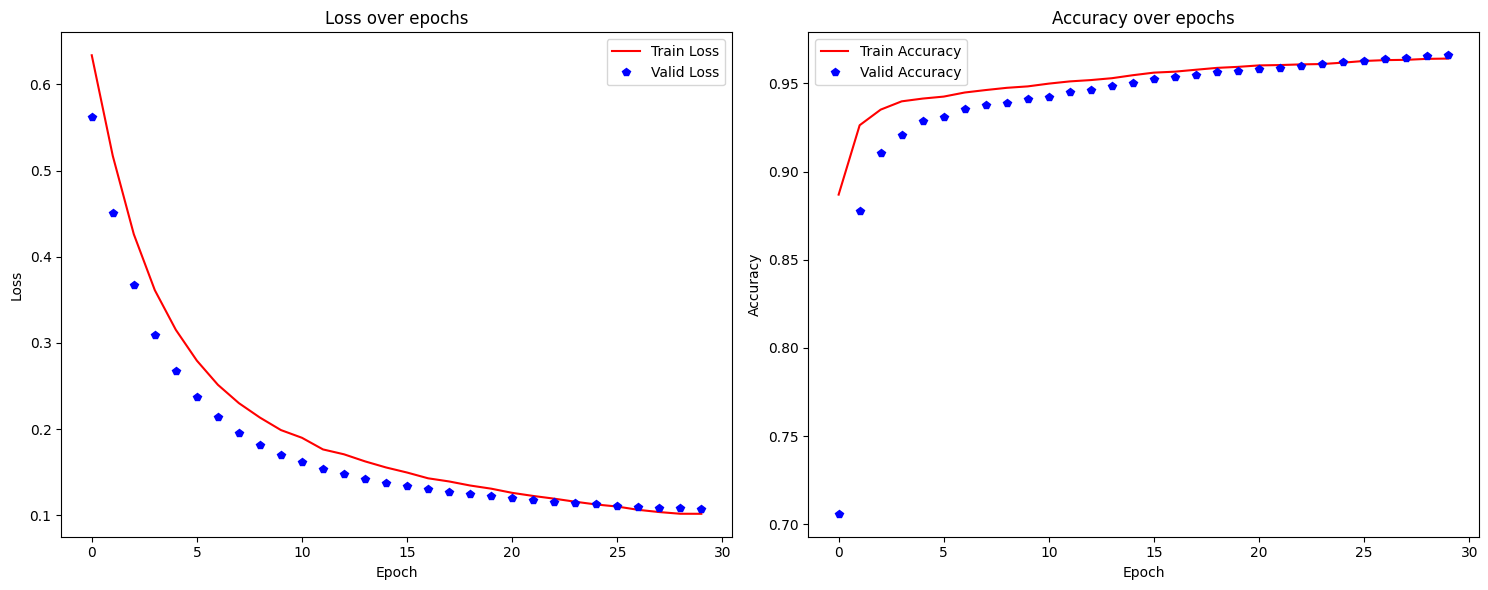

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].plot(train_losses, "r", label="Train Loss")
ax[0].plot(valid_losses, "bp", label="Valid Loss")
ax[0].set_title("Loss over epochs")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[0].set_ylabel("Loss")

ax[1].plot(train_accuracies, "r", label="Train Accuracy")
ax[1].plot(valid_accuracies, "bp", label="Valid Accuracy")
ax[1].set_title("Accuracy over epochs")
ax[1].set_xlabel("Epoch")
ax[1].legend()
ax[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

### Interface to call the model prediction

In [24]:
def predict_email(email, model, vectorizer, device, top_n=5):
    model.eval()
    
    email_csrmatrix = vectorizer.transform([email])
    email_coomatrix = email_csrmatrix.tocoo()
    indices = tensor([email_coomatrix.row, email_coomatrix.col]).to(device)
    values = tensor(email_coomatrix.data, dtype=torch.float32).to(device)
    email_tensor = torch.sparse_coo_tensor(indices, values, torch.Size(email_coomatrix.shape)).to_dense().to(device)
    
    with torch.no_grad():
        outputs = model(email_tensor)
        _, prediction = torch.max(outputs, 1)
        
        first_layer_weights = model.layers[0].weight.data.cpu().numpy()
        suspicious_weights = first_layer_weights[1]
        
        word_importance = email_tensor[0].cpu() * suspicious_weights
        important_words_indices = np.argsort(word_importance)[-top_n:]
        
        important_words = [vectorizer.get_feature_names_out()[i] for i in important_words_indices]
        important_scores = [word_importance[i] for i in important_words_indices]
        
        important_scores = tensor(important_scores).softmax(dim=0)
        important_scores = [score * 100 for score in important_scores]
    
    return prediction.item(), torch.softmax(outputs, dim=1).cpu().numpy(), list(zip(important_words, important_scores))

In [34]:
sus_mail = """Dear Valued Customer,

We have detected unusual activity in your account and need to verify your identity to ensure the security of your personal information. Please click the link below to verify your account:

Verify Your Account

Failure to verify your account within 24 hours will result in a temporary suspension of your account.

If you did not initiate this request, please contact our support team immediately.

Thank you for your prompt attention to this matter.

Sincerely,
Your Bank Support Team"""

ok_mail = """Hey [Your Name],

I hope you're doing well! It's been a while since we last caught up, and I was thinking it would be great to hang out sometime soon. How about grabbing coffee this weekend?

Let me know if you're free, or if another time works better for you. I’d love to hear what you’ve been up to lately and share some updates on my end too!

Looking forward to seeing you soon.

Take care,
[Friend's Name]

P.S. If you're busy this weekend, no worries—we can plan for another time! :)"""
 
sus, confidency, words = predict_email(ok_mail, model, vectorizer, device, top_n=10)

print(f"Sus: {sus}, Confidence: {confidency.max() * 100:.2f}, Words: {words}")

Sus: 0, Confidence: 97.68, Words: [('well', tensor(9.8972)), ('id', tensor(9.9040)), ('think', tensor(9.9127)), ('would', tensor(9.9268)), ('time', tensor(9.9468)), ('hey', tensor(9.9555)), ('anoth', tensor(10.0013)), ('weekend', tensor(10.1121)), ('forward', tensor(10.1154)), ('your', tensor(10.2281))]


C:\Users\sqdar\AppData\Local\Temp\ipykernel_2040\1932624220.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  word_importance = email_tensor[0].cpu() * suspicious_weights


In [32]:
# Validate on test data set
losses, accuracies = [], []
total_loss, total_acc, count = 0., 0., 0.
 
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        predictions = model(x_batch)
        loss = loss_function(predictions, y_batch.view(-1))
        count += len(x_batch)
        total_loss += loss.item()
        acc = accuracy(predictions, y_batch)
        total_acc += acc * len(x_batch)
    losses.append(total_loss / count)
    accuracies.append(total_acc / count)
    
print(f"Loss: {total_loss / count}, Accuracy: {total_acc / count}")

Loss: 0.001746331895778341, Accuracy: 0.9621986106247169
